In [1]:
%matplotlib inline
import numpy
import matplotlib
from matplotlib import pylab, mlab, pyplot
np = numpy
plt = pyplot
from matplotlib.pyplot import *
import os
import glob

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs

from pylab import *
from numpy import *

import pandas as pd

from ipywidgets.widgets import interact, interactive, fixed
from ipywidgets import widgets
from scipy import fftpack
from IPython.display import display
from PIL import Image
import pims
import scipy.optimize as optimization
import pandas as pd

import trackpy
import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets

import ipywidgets as widgets
import io

In [2]:
import os
import re
import glob

def make_filelist(commonpath,pattern):
    #commonpath="C:\\Users\\Public\\Pictures\\HS_XCS_EtOH_1545"
    #pattern = '*.xml'
    filelist = []
    for root, dirs, files in os.walk(commonpath):
        filelist += glob.glob(os.path.join(root,pattern))
    try:
        filelist.remove('/home/caggioni.m/dashboards/DVA/2D_glass/')
    except:
        pass
    try:
        filelist.remove('/home/caggioni.m/dashboards/DVA/2D_glass/.ipynb_checkpoints/')
    except:
        pass
    
    return filelist

filelist=make_filelist('/home/caggioni.m/dashboards/DVA/2D_glass/','')

select_video_list=widgets.Dropdown(description='Video List',options=filelist)

In [3]:
def update_data(sender):
    global video
    video=pims.ImageSequence(sender['new'])
    info={'interval': 1, #interval between frames in sec
          'muperpix': 0.152, #spatial calibration of the image micron per pixel
          'filename': 'video'
         }
    video.info=info
    video=calculate_variance_decay(video)
    chi4({'new':1})
    delta_video(1,1) 
    wid_delta_video.children[0].max=len(video)
    wid_delta_video.children[1].max=len(video)


def _calculate_diff_variance(video,framenum,delta):
    
    frames=len(video)
    interval=video.info['interval']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    
    im1=video[framenum].astype(np.float)
    im2=video[framenum+delta].astype(np.float)
    imdiff=im2-im1
    return var(imdiff)

def calculate_variance_decay(video,deltalist=None,naverage=50):
    
    frames=len(video)
    interval=video.info['interval']
    
    if not (deltalist):
        deltalist=unique(logspace(0,log10(frames),num=20, endpoint=False, base=10.0,dtype=int))
    
    varlist=[]
    var_varlist=[]
    
    for delta in deltalist:
        framelist=range(0,frames-delta,int((frames-delta)/naverage))
        varvalue=[]
        for framenum in framelist:
            varvalue.append(_calculate_diff_variance(video,framenum,delta))
        varlist.append(mean(varvalue))
        var_varlist.append(var(varvalue))
        
    variance_normalized=(varlist-min(varlist))/(max(varlist)-min(varlist))
    video.info['variance_decay']=pd.DataFrame({'deltat':multiply(deltalist,interval),
                                               'variance':varlist,
                                               'var_normalized':variance_normalized,
                                               'varvar':var_varlist})
    
    return video

def plot_variance_decay(video):
    plot(video.info['variance_decay'].deltat,video.info['variance_decay'].variance,'o')
    errorbar(video.info['variance_decay'].deltat,video.info['variance_decay'].variance,xerr=0,yerr=video.info['variance_decay'].varvar)
    xscale('log')
    xlabel('leg time [s]')
    ylabel('diff frame mean variance')
    
def delta_video(frame,delta):
    fig, ax = subplots(figsize=(5,5));

    im1=video[frame].astype(np.float)
    im2=video[frame+delta].astype(np.float)
    imdiff=im2-im1
    ax.imshow(imdiff,cmap=my_cmap); #vmin=-180, vmax=180
    ax.axis('off')
    ax.axis('equal')

    output=io.BytesIO()
    fig.savefig(output,type='jpg',width=640,height=480);
    close(fig)
    wid_interact.value = output.getvalue();
    output.close();
    
    ax.imshow(im2,cmap='gray');
    ax.axis('off')
    ax.axis('equal')
    output=io.BytesIO()
    fig.savefig(output,type='jpg',width=640,height=480);
    close(fig)
    wid_orig.value = output.getvalue();
    output.close();
    
def chi4(delta):
    fig, ax = subplots(figsize=(5,5));
    
    ax.plot(video.info['variance_decay']['deltat'],video.info['variance_decay']['varvar'])
    xlabel('delta frames')
    ylabel('$\chi_4$')
    xscale('log')
    ax.axvline(delta['new'],color='r')

    output=io.BytesIO()
    fig.savefig(output,type='jpg',width=640,height=480);
    close(fig)
    wid_chi4.value = output.getvalue();
    output.close();
    
    wid_delta_video.children[0].max=len(video)-1-delta['new']

In [4]:
select_video_list.observe(update_data, names='value')

wid_chi4=widgets.Image()
wid_chi4.height=350
wid_chi4.width=350

wid_interact=widgets.Image()
wid_interact.height=300
wid_interact.width=300

wid_orig=widgets.Image()
wid_orig.height=300
wid_orig.width=300

wid_delta_video=widgets.interactive(delta_video,
                                    frame=widgets.IntSlider(min=0, max=100, step=1, value=0),
                                    delta=widgets.IntSlider(min=1, max=100, step=1, value=0))
wid_delta_video.children[1].observe(chi4,names='value')
my_cmap = matplotlib.cm.get_cmap('seismic')

play_video=widgets.Play(description='Play',interval=100,min=0,max=wid_delta_video.children[0].max)
widgets.jslink((play_video, 'value'), (wid_delta_video.children[0], 'value'))
widgets.jslink((play_video, 'max'), (wid_delta_video.children[0], 'max'))

In [5]:
display(select_video_list)
update_data({'new':select_video_list.value})

ValueError: range() arg 3 must not be zero

KeyError: 'variance_decay'

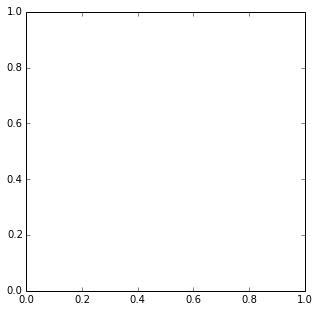

In [6]:
display(wid_delta_video)
display(widgets.HBox(children=[wid_orig,wid_chi4,wid_interact]))
display(play_video)